# Install ORTEGA

In [15]:
!pip install ortega

In [12]:
import pandas as pd
import ortega

# Read movement data of two moving entities
The input data must contain following fields: unique id for the two moving entities, and longitude, latitude, and local time for each tracking point.

The time field must be converted to datetime type and the value must contains year, month, day, hour, minute, and second. 

In [3]:
bigdata = pd.read_csv('/path/Mother_Cub1.csv', sep=',',header=0)
bigdata['Time_LMT'] = pd.to_datetime(bigdata.Time_LMT)
print('total number of gps points:', bigdata.shape[0])

total number of gps points: 10414


# Create ORTEGA object and implement interaction analysis
Parameters of ORTEGA class:
1. start_time, end_time: They can be used to select the portion of movement data that falls in this time interval.
2. minute_delay: The allowable time lag parameter in minutes. Usually, this number should be greater than the temporal resolution of movement data.
3. max_el_time_min: If the time interval between two consecutive points is larger than this parameter, ORTEGA will not create PPA and treat this time interval as a stationary activity when individuals are not moving.
4. latitude_field, longitude_field, id_field, time_field: users need to specify the field names based on the data they used.

In [4]:
interaction1 = ortega.ORTEGA(data=bigdata,
                             start_time='2020-01-01 00:00:00',  ##set a time window to subset data
                             end_time='2020-01-10 00:00:00',
                             minute_delay=60,
                             time_field='Time_LMT',
                             id_field='idcollar'
                             )

2023-02-14 14:35:30.242399 Initializing ORTEGA object...
2023-02-14 14:35:30.245625 Generate PPA list for the two moving entities...
2023-02-14 14:35:30.317700 Generating PPA list completed!
2023-02-14 14:35:30.381414 Initialization success!


The below cell runs interaction_analysis() and it returns three values. 
- The first value is a list of intersecting PPA pairs as paired built-in Ellipse objects.
- The second return value is a dataframe containing all intersecting PPA pairs. 
- The third return value is a dataframe that includes all identified continuous interaction segments (interaction events).

In [5]:
intersecting_ellipse_list, df_intersecting_PPAs, df_duration = interaction1.interaction_analysis()

2023-02-14 14:35:31.386897 Implement interaction analysis...
2023-02-14 14:35:31.387143 Getting spatial and temporal intersection pairs...
2023-02-14 14:35:31.945582 Getting spatial and temporal intersection pairs completed!
2023-02-14 14:35:31.945681 Complete! 244 pairs of intersecting PPAs found!
2023-02-14 14:35:31.948611 Compute duration of interaction...
2023-02-14 14:35:31.963560 Complete! 10 interaction events identified!


The beblow results indicate 10 interaction events between these two moving entities.
The dataframe df_duration includes six columns: 
- No: event no. sorted by start time
- P1: unique id for individual 1
- P2: unique id for individual 2
- Start: start time of the interaction
- End: end time of the interaction
- Duration: duration of the interaction event (in minutes)

In [6]:
df_duration

,No,P1,P2,Start,End,Duration
0,1,131343,229012,2020-01-01 13:00:00,2020-01-02 09:00:00,1200.0
1,2,131343,229012,2020-01-02 14:00:00,2020-01-03 09:00:00,1140.0
2,3,131343,229012,2020-01-03 12:00:00,2020-01-03 16:00:00,240.0
3,4,131343,229012,2020-01-03 18:00:00,2020-01-04 04:00:00,600.0
4,5,131343,229012,2020-01-04 05:00:00,2020-01-04 09:00:00,240.0
5,6,131343,229012,2020-01-04 10:00:00,2020-01-04 22:00:00,720.0
6,7,131343,229012,2020-01-06 04:00:00,2020-01-06 21:00:00,1020.0
7,8,131343,229012,2020-01-07 18:00:00,2020-01-08 12:00:00,1080.0
8,9,131343,229012,2020-01-08 13:00:00,2020-01-08 22:00:00,540.0
9,10,131343,229012,2020-01-09 01:00:00,2020-01-09 10:00:00,540.0


# Compute PPA size and use violin plots to show the distribution

In [8]:
ppasize_list = ortega.ppastatistics.compute_ppa_size(interaction1)

Statistics of PPA ellipses length for id 131343:
mean: 0.01161074718266669
min: 0.00022408865054548323
max: 0.09267464512198141
median: 0.004578985825704032
std: 0.015371685865235754
Statistics of PPA ellipses length for id 229012:
mean: 0.004640548503751784
min: 0.00022629652751446434
max: 0.07247084259039922
median: 0.0017392335752117846
std: 0.007524990336665188


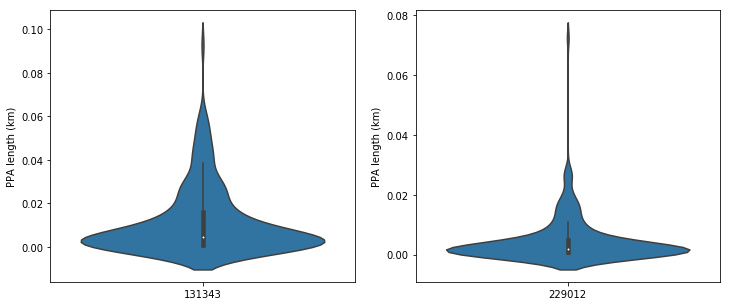

In [18]:
import seaborn
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=ppasize_list['size_list1'], ax=ax1)
seaborn.violinplot(data=ppasize_list['size_list2'], ax=ax2)
ax1.set_xticklabels([str(interaction1.id1)])
ax2.set_xticklabels([str(interaction1.id2)])
ax1.set_ylabel('PPA length (km)')
ax2.set_ylabel('PPA length (km)')
plt.show()

# Compute PPA interval and use violin plot to show the distribution

In [9]:
interval_list = ortega.ppastatistics.compute_ppa_interval(interaction1)

Statistics of PPA ellipses time interval (minutes) for id 131343:
mean: 61.4218009478673
min: 57.0
max: 122.00000000000001
median: 60.0
std: 9.237980534737535
Statistics of PPA ellipses time interval (minutes) for id 229012:
mean: 62.30769230769231
min: 57.0
max: 300.0
median: 60.0
std: 18.547537525828538


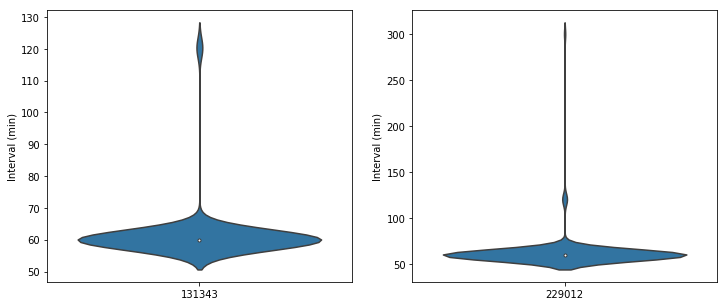

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=interval_list[0].tolist(), ax=ax1)
seaborn.violinplot(data=interval_list[1].tolist(), ax=ax2)
ax1.set_xticklabels([interaction1.id1])
ax2.set_xticklabels([interaction1.id2])
ax1.set_ylabel('Interval (min)')
ax2.set_ylabel('Interval (min)')
plt.show()

# Map the results of interaction analysis
two tracks are shown in blue and red ellipses respectively, intersecting PPAs are highlighted in yellow

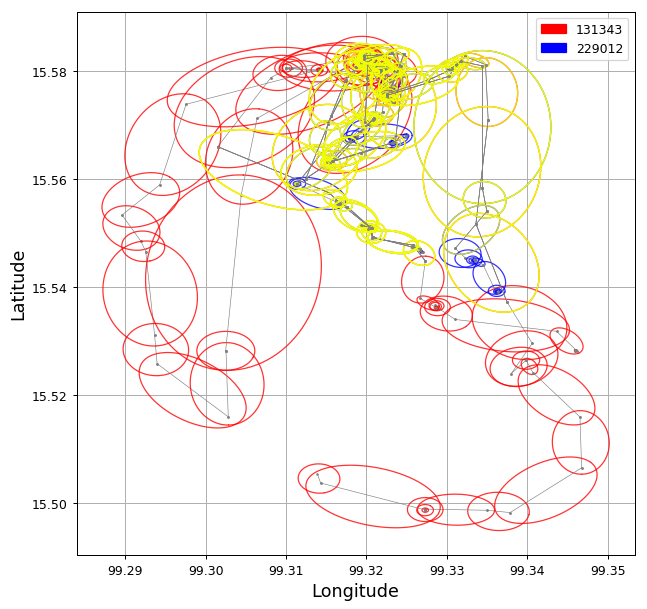

In [10]:
ortega.visualization.plot_interaction(interaction1, intersecting_ellipse_list)

map the original tracks without annotating intersecting portion

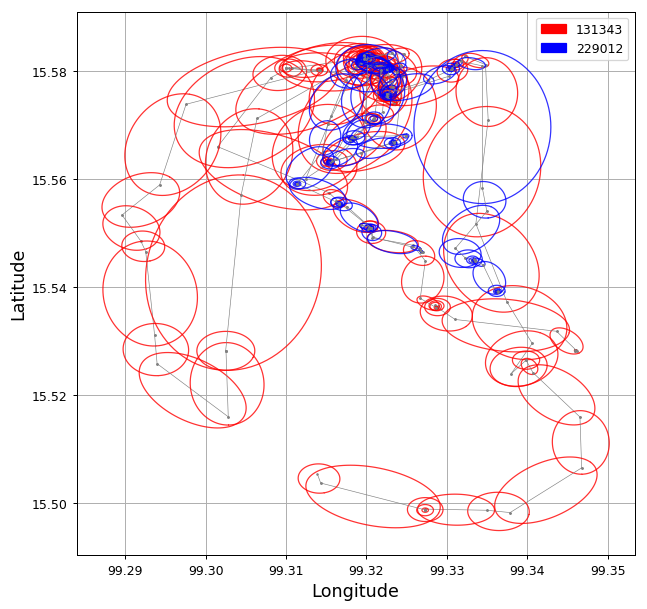

In [11]:
ortega.visualization.plot_original_tracks(interaction1) 

# Explore the difference in speed and movement  direction when individuals interact

Statistics of percentage difference in movement speed between intersecting PPAs:
count    244.000000
mean       1.025526
std        0.596426
min        0.004261
25%        0.520954
50%        1.030559
75%        1.513665
max        1.993448
Name: diff_speed, dtype: float64


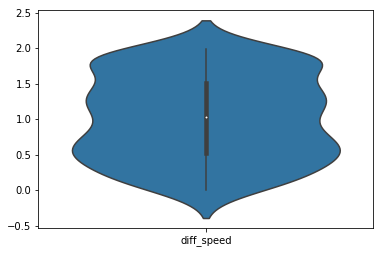

In [34]:
df_pair_speed = ortega.ppastatistics.compute_ppa_speed(df_intersecting_PPAs)
ax = seaborn.violinplot(data=df_pair_speed['diff_speed'])
ax.set_xticklabels(['diff_speed'])
plt.show()

Statistics of difference in movement direction between intersecting PPAs:
count    244.000000
mean      80.124632
std       55.679257
min        0.262960
25%       29.370761
50%       76.073549
75%      127.777994
max      178.955497
Name: diff_angle, dtype: float64


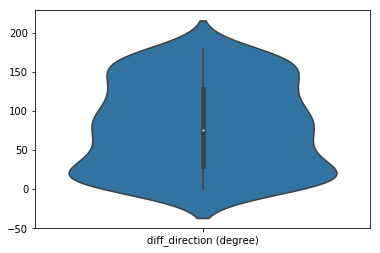

In [35]:
df_pair_angle = ortega.ppastatistics.compute_ppa_direction(df_intersecting_PPAs)
ax = seaborn.violinplot(data=df_pair_angle['diff_angle'])
ax.set_xticklabels(['diff_direction (degree)'])
plt.show()